# data exploration and comparison to the original data set

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
train = pd.read_csv('train.csv')
train.drop(columns='id', inplace=True)
test = pd.read_csv('test.csv')
test.drop(columns='id', inplace=True)
orig = pd.read_csv('original.csv')

In [3]:
train.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [13]:
test.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.5498,0.424867
1,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.6643,0.846000
2,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.0127,0.134067
3,0.885793,-5.598049,0.118488,0.000005,0.376906,0.134435,0.487740,271790.3989,0.316467
4,0.637391,-7.068160,0.126099,0.539073,0.068950,0.024300,0.591248,277728.5383,0.481067


In [4]:
orig.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0.513080,-7.811659,0.071013,0.064564,0.109495,0.316042,0.736929,328639.3188,0.556200,117.092439
1,0.775393,-6.819409,0.023500,0.510599,0.187498,0.024361,0.259488,271967.9826,0.410533,122.002279
2,0.636408,-19.782248,0.063451,0.427861,0.002226,0.024300,0.054848,186147.0029,0.533333,149.130616
3,0.232190,-14.957299,0.023500,0.076268,0.000001,0.228454,0.744650,321734.9723,0.658533,95.832178
4,0.758564,-4.715966,0.023500,0.263551,0.414794,0.197167,0.966592,179973.3982,0.230467,125.696263


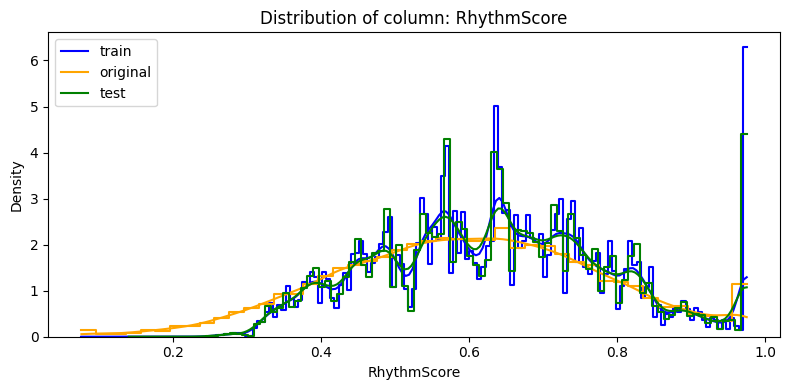

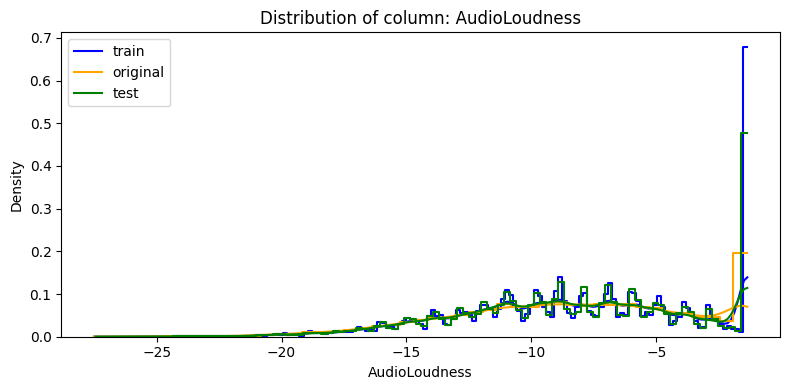

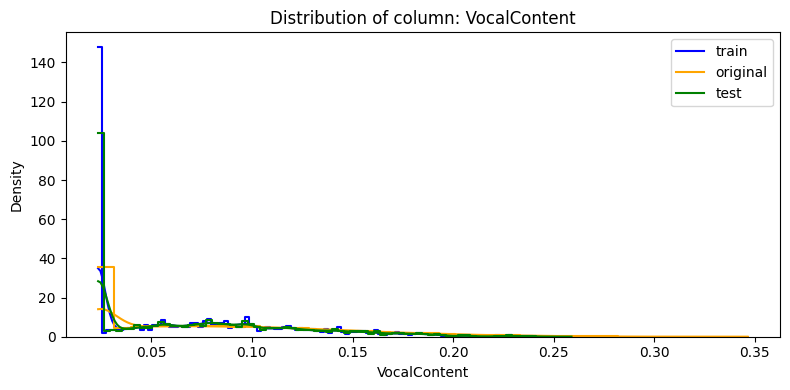

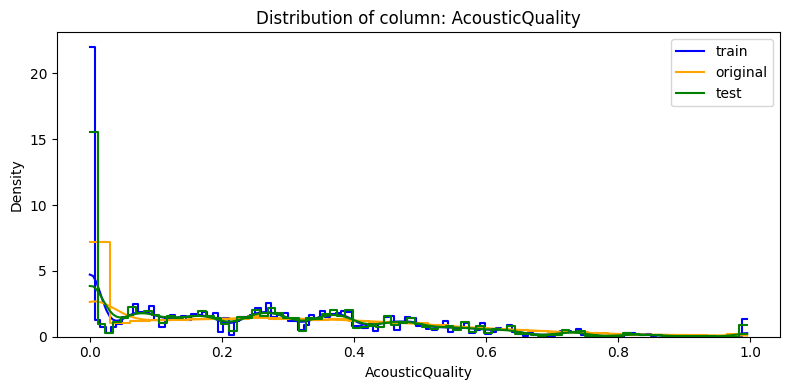

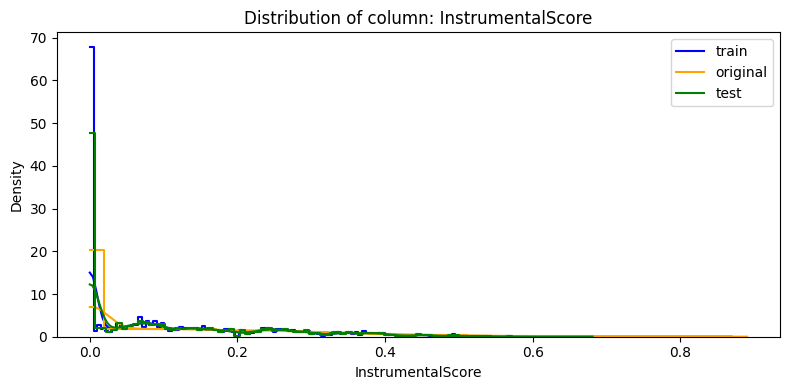

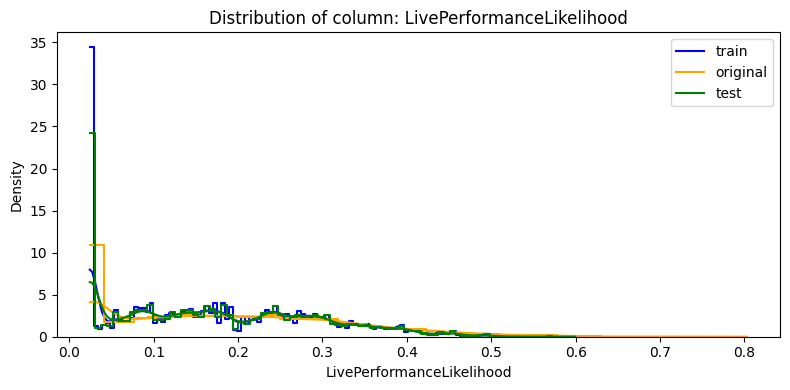

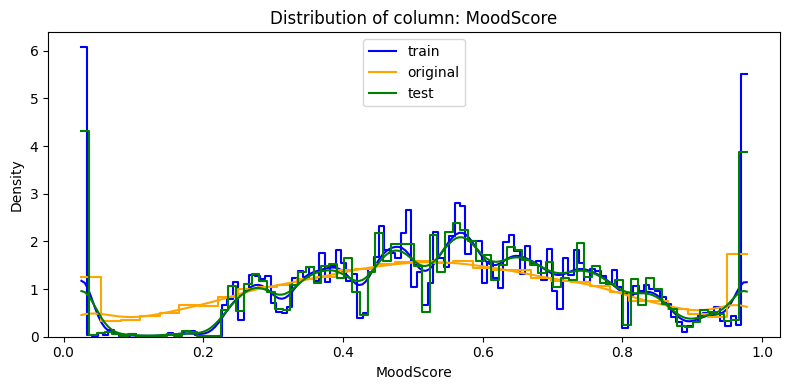

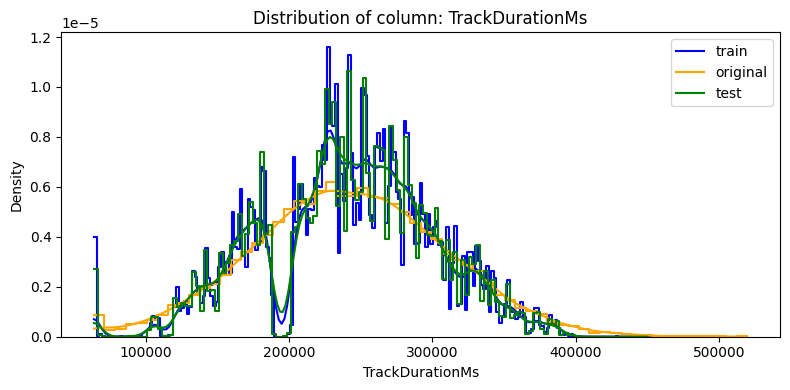

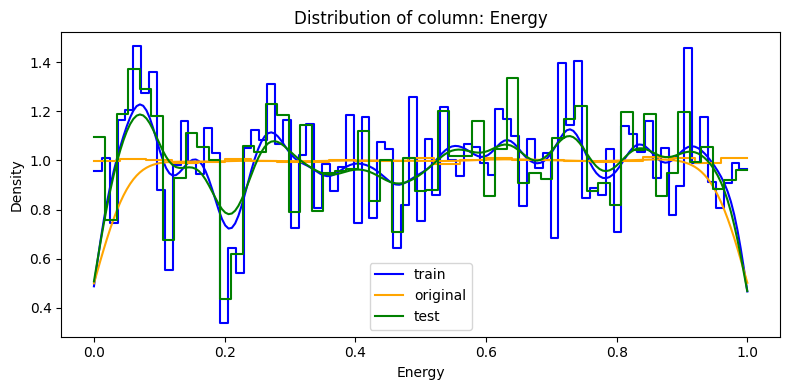

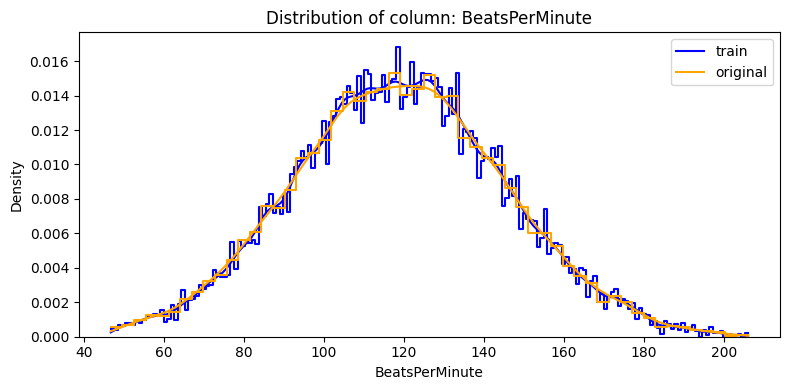

In [17]:
for col in train.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(train[col], color='blue', label='train', kde=True, stat='density', element='step', fill=False)
    sns.histplot(orig[col], color='orange', label='original', kde=True, stat='density', element='step', fill=False)
    try:
        sns.histplot(test[col], color='green', label='test', kde=True, stat='density', element='step', fill=False)
    except KeyError:
        pass
    
    plt.title(f'Distribution of column: {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

The distributions look similar overall, but the training data has notably more noise, especially for: RythmScore, MoodScore, TrackDurationMs, Energy

Many columns have peaks towards the lower or upper limits, that are not present in the original data -> artifacts? The test data has these too (though a bit lower), so fixing them would be wrong.

## column transformations?
AudioLoudness, VocalContent, AcousticQuality, InstrumentalScore, LivePerformanceLikelihood

In [23]:
from sklearn.preprocessing import PowerTransformer

def transform_column(dfs, col):
    combined = pd.concat([df[col] for df in dfs], ignore_index=True).values.reshape(-1, 1)
    
    transformer = PowerTransformer(method='yeo-johnson')
    transformed = transformer.fit_transform(combined)
    
    lengths = [len(df) for df in dfs]
    transformed_arrays = np.split(transformed.flatten(), np.cumsum(lengths)[:-1])
    
    return transformed_arrays

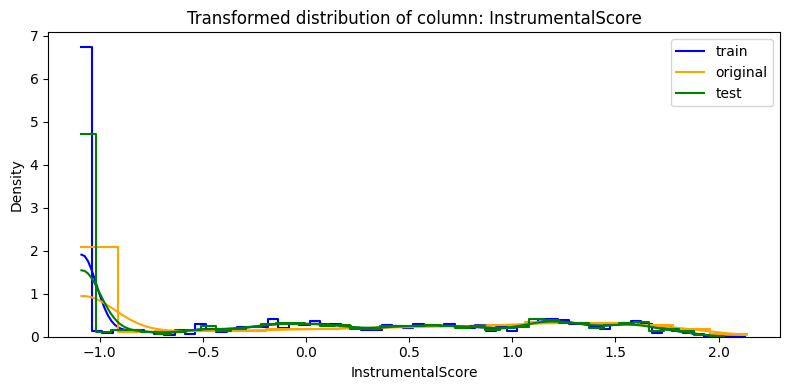

In [25]:
col = 'InstrumentalScore'

transformed = transform_column([train, orig, test], col)

plt.figure(figsize=(8, 4))
sns.histplot(transformed[0], color='blue', label='train', kde=True, stat='density', element='step', fill=False)
sns.histplot(transformed[1], color='orange', label='original', kde=True, stat='density', element='step', fill=False)
sns.histplot(transformed[2], color='green', label='test', kde=True, stat='density', element='step', fill=False)

plt.title(f'Transformed distribution of column: {col}')
plt.xlabel(col)
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

-> doesn't change much, so not worth it

## explore mutual information

In [26]:
from sklearn.feature_selection import mutual_info_regression

target_col = 'BeatsPerMinute'

X = train.drop(columns=[target_col])
y = train[target_col]

mi = mutual_info_regression(X, y, random_state=0)

mi_series = pd.Series(mi, index=X.columns)
mi_series = mi_series.sort_values(ascending=False)

print("Mutual Information with target:")
print(mi_series)

Mutual Information with target:
VocalContent                 0.002827
Energy                       0.001207
AcousticQuality              0.001182
RhythmScore                  0.000662
LivePerformanceLikelihood    0.000483
TrackDurationMs              0.000347
InstrumentalScore            0.000321
AudioLoudness                0.000158
MoodScore                    0.000069
dtype: float64


In [27]:
X = orig.drop(columns=[target_col])
y = orig[target_col]

mi = mutual_info_regression(X, y, random_state=0)

mi_series = pd.Series(mi, index=X.columns)
mi_series = mi_series.sort_values(ascending=False)

print("Mutual Information with target:")
print(mi_series)

Mutual Information with target:
TrackDurationMs              0.007819
RhythmScore                  0.006577
LivePerformanceLikelihood    0.001358
MoodScore                    0.001181
AudioLoudness                0.000000
VocalContent                 0.000000
AcousticQuality              0.000000
InstrumentalScore            0.000000
Energy                       0.000000
dtype: float64


Surprisingly, the original data shows no MI for over half of the columns!

In [5]:
def target_encode_with_original_data(df: pd.DataFrame, orig: pd.DataFrame) -> pd.DataFrame:
    """ Use the original data for a type of target encoding.
    Args:
        df (pd.DataFrame): DataFrame to add the TE to.
        orig (pd.DataFrame): The original data.
    Returns:
        pd.DataFrame: DataFrame with added columns.
    """
    for col in [c for c in df.columns if c != TARGET_COL]:
        tmp_df = orig.groupby(col)[TARGET_COL].mean()
        tmp_df.name = f"TEO_{col}"
        df = df.merge(tmp_df, on=col, how='left')

    return df

In [8]:
TARGET_COL = 'BeatsPerMinute'
train = target_encode_with_original_data(train, orig)

In [9]:
train.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute,TEO_RhythmScore,TEO_AudioLoudness,TEO_VocalContent,TEO_AcousticQuality,TEO_InstrumentalScore,TEO_LivePerformanceLikelihood,TEO_MoodScore,TEO_TrackDurationMs,TEO_Energy
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020,128.943777,103.670696,119.570449,118.492798,118.792949,138.557926,139.722601,NaN,137.242701
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.963370
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989,159.284538,111.784954,134.719175,104.163991,112.953866,94.881051,119.429846,131.578397,160.729156
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212,55.768044,120.369246,107.967941,119.076562,147.602331,104.047395,85.263665,NaN,59.022426
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511,NaN,NaN,119.570449,NaN,118.792949,NaN,NaN,NaN,53.560673
